In [3]:
import sys
import os

python_exe = sys.executable
print("Current Python executable path:", python_exe)

Current Python executable path: D:\prj2\.venv\Scripts\python.exe


In [4]:
import gc
import random

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.decomposition import PCA, IncrementalPCA
from tensorflow.keras.layers import Input, Embedding, Conv2D, GlobalMaxPooling2D, Concatenate, Dense, Dropout, Reshape
from tensorflow.keras.models import Model

## Constants

In [5]:
root_dir = './processed/'
TOTAL_ADWARE_SAMPLE = 1514
TOTAL_BANKING_SAMPLE = 2505
TOTAL_SMS_SAMPLE = 4928
SAMPLE_SIZE = 1500

In [6]:
def get_data(label, count, total=1500):
    data = []
    samples = random.choices(range(600, 600 + total), k=count)
    for i in samples:
        filepath = os.path.join(root_dir, f'{label}/{label}_{str(i).zfill(4)}/data_section.bin')
        if not os.path.exists(filepath):
            continue
        try:
            with open(filepath, 'rb') as f:
                file_data = f.read()
                bytes_sequence = np.frombuffer(file_data, dtype=np.uint8)
                data.append(bytes_sequence)
        except Exception as e:
            print(f"[{label}] Error reading {filepath}: {e}")
    print(f"[{label}] Loaded {len(data)} samples")
    return data

In [15]:
def get_benign_data(count=1000):
    data = []
    i = 600
    tried = 0
    max_attempts = count * 2

    while len(data) < count and tried < max_attempts:
        filepath = os.path.join(root_dir, f"Benign/Benign_{str(i).zfill(4)}/data_section.bin")
        if os.path.exists(filepath):
            try:
                with open(filepath, 'rb') as f:
                    file_data = f.read()
                    bytes_sequence = np.frombuffer(file_data, dtype=np.uint8)
                    data.append(bytes_sequence)
            except Exception as e:
                print(f"[Benign] Error reading {filepath}: {e}")
        else:
            print(f"[Benign] File not found: {filepath}")
        i += 1
        tried += 1
    print(f"[Benign] Loaded {len(data)} samples")
    return data

In [16]:
gc.collect()
benign_data = get_benign_data()
adware_data = get_data('Adware', TOTAL_ADWARE_SAMPLE, 1500)
sms_data = get_data('SMS', TOTAL_SMS_SAMPLE, 4800)
banking_data = get_data('Banking', TOTAL_BANKING_SAMPLE, 2200)
MALWARE_SAMPLE = TOTAL_ADWARE_SAMPLE + TOTAL_SMS_SAMPLE + TOTAL_BANKING_SAMPLE
BENIGN_SAMPLE = len(benign_data)
gc.collect()

[Benign] Loaded 1000 samples
[Adware] Loaded 1514 samples
[SMS] Loaded 4926 samples
[Banking] Loaded 2473 samples


0

In [17]:
labels = np.array([0 for i in range(BENIGN_SAMPLE)] + [1 for i in range(MALWARE_SAMPLE)])

In [18]:
TRUNCATED_LEN = 1536000

def truncate(data_list, max_len=TRUNCATED_LEN):
    return np.array([
        x[:max_len] if len(x) >= max_len else np.pad(x, (0, max_len - len(x)))
        for x in data_list
    ])

# Step 1: Prepare consistent input
benign_trimmed = truncate(benign_data[:200])
adware_trimmed = truncate(adware_data[:200])
sms_trimmed = truncate(sms_data[:200])
banking_trimmed = truncate(banking_data[:200])

all_data = np.concatenate([benign_trimmed, adware_trimmed, sms_trimmed, banking_trimmed], axis=0)

print("Shape of all_data:", all_data.shape)  # should be (800, 10000)

# Step 2: Initialize IncrementalPCA
ipca = IncrementalPCA(n_components=256)
batch_size = 256  # or higher if your system allows

for i in range(0, all_data.shape[0], batch_size):
    batch = all_data[i:i + batch_size]
    ipca.partial_fit(batch)

pca_pre = ipca.transform(all_data)

Shape of all_data: (800, 1536000)


In [19]:
def transform_data(data):
    data = truncate(data)  # Pad/truncate to correct size
    n_part = len(data) // 1000
    parts = [data[i*1000:(i+1)*1000] for i in range(n_part)] + [data[n_part*1000:]]

    res = []
    for part in parts:
        if len(part) == 0:
            continue  # Skip empty batch
        res.extend(ipca.transform(part))

    gc.collect()
    return np.array(res)

In [20]:
gc.collect()
features_pca_benign = transform_data(benign_data)
features_pca_adware = transform_data(adware_data)
features_pca_sms = transform_data(sms_data)
features_pca_banking = transform_data(banking_data)

features_pca = np.concatenate((features_pca_benign, features_pca_adware, features_pca_sms, features_pca_banking), axis=0)

In [21]:
print(len(features_pca))

9913


In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_pca)

print(len(features_pca_benign))
print(len(features_pca_adware))
print(len(features_pca_sms))
print(len(features_pca_banking))
print(features_scaled.shape)

labels = np.concatenate((
    np.full(len(features_pca_benign), 0),  # Benign
    np.full(len(features_pca_adware), 1),  # Malware
    np.full(len(features_pca_sms), 1),     # Malware
    np.full(len(features_pca_banking), 1)  # Malware
))

print(len(labels), features_scaled.shape[0])

1000
1514
4926
2473
(9913, 256)
9913 9913


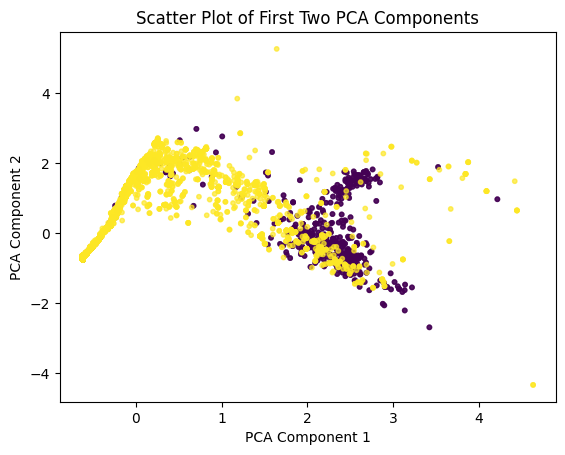

In [51]:
import matplotlib.pyplot as plt
plt.scatter(features_scaled[:, 0], features_scaled[:, 1], c=labels, cmap='viridis', alpha=0.7, s=10)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Scatter Plot of First Two PCA Components')
plt.show()

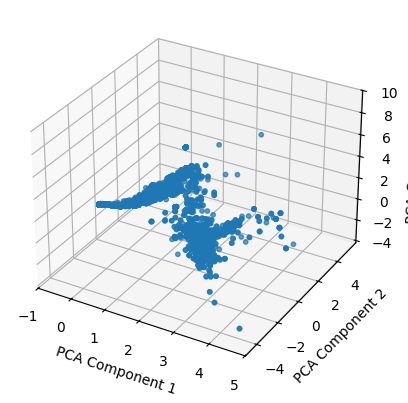

In [52]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_scaled[:, 0], features_scaled[:, 1], features_scaled[:, 2], alpha=0.7, s=10)
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.show()

In [23]:
min_val = np.min(features_pca, axis=0)  # Use numpy here for compatibility
max_val = np.max(features_pca, axis=0)
features_scaled = 2 * (features_pca - min_val) / (max_val - min_val) - 1  # Scale to [-1, 1]

# Reshape features to (None, 16, 16, 1)
features_reshaped = np.reshape(features_scaled, [-1, 16, 16, 1])  # Adjust to match data shape

# Convert features and labels to TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((features_reshaped, labels))


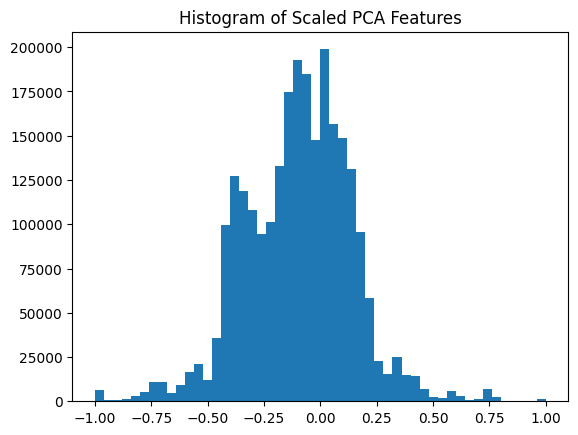

In [54]:
plt.hist(features_scaled.flatten(), bins=50)
plt.title('Histogram of Scaled PCA Features')
plt.show()


In [24]:
NUMBER_OF_SAMPLE = MALWARE_SAMPLE + BENIGN_SAMPLE

In [25]:
# Shuffle the dataset
dataset = dataset.shuffle(buffer_size=NUMBER_OF_SAMPLE, seed=123)

# Split into training and validation datasets
train_size = int(0.8 * NUMBER_OF_SAMPLE)  # 80% for training
train_dataset = dataset.take(train_size)  # First 80%
val_dataset = dataset.skip(train_size)    # Remaining 20%

# Batch the datasets
batch_size = 64  # You can adjust this
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)


In [26]:
for x_batch, y_batch in train_dataset.take(1):
    print("Input batch shape:", x_batch.shape)
    print("Label batch shape:", y_batch.shape)

Input batch shape: (64, 16, 16, 1)
Label batch shape: (64,)


In [58]:
# Define input
input_layer = Input(shape=(16, 16, 1), name="Input_Layer")

# Convolutional and pooling layers
conv_layers = []
for kernel_size in [2, 3, 4, 5, 6, 7, 8]:
    x = Conv2D(filters=64, kernel_size=(kernel_size, kernel_size), activation='relu', padding='same',
               name=f"Conv2D_Kernel_{kernel_size}")(input_layer)
    x = Dropout(0.3, name=f"Dropout_Conv2D_{kernel_size}")(x)
    pooled = GlobalMaxPooling2D(name=f"GlobalMaxPooling_Kernel_{kernel_size}")(x)
    conv_layers.append(pooled)

# Aggregation
aggregation_layer = Concatenate(name="Aggregation_Layer")(conv_layers)
aggregation_layer = Dropout(0.5, name="Dropout_Aggregation")(aggregation_layer)
# Fully connected layer with Dropout
fully_connected = Dense(128, activation='relu', name="Fully_Connected_Layer")(aggregation_layer)
dropout_layer = Dropout(0.5, name="Dropout_Layer")(fully_connected)

# Output layer
output_layer = Dense(2, activation='softmax', name="Output_Layer")(dropout_layer)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer, name="CNN_Model")

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)      │ (None, 16, 16, 1)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv2D_Kernel_2 (Conv2D)      │ (None, 16, 16, 64)        │             320 │ Input_Layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv2D_Kernel_3 (Conv2D)      │ (None, 16, 16, 64)        │             640 │ Input_Layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv2D_Kernel_4 (Conv2D)      │ (None, 16, 16, 64)        │           1,088 │ Input_Layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv2D_Kernel_5 (Conv2D)      │ (None, 16, 16, 64)        │           1,664 │ Input_Layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv2D_Kernel_6 (Conv2D)      │ (None, 16, 16, 64)        │           2,368 │ Input_Layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv2D_Kernel_7 (Conv2D)      │ (None, 16, 16, 64)        │           3,200 │ Input_Layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv2D_Kernel_8 (Conv2D)      │ (None, 16, 16, 64)        │           4,160 │ Input_Layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Dropout_Conv2D_2 (Dropout)    │ (None, 16, 16, 64)        │               0 │ Conv2D_Kernel_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Dropout_Conv2D_3 (Dropout)    │ (None, 16, 16, 64)        │               0 │ Conv2D_Kernel_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Dropout_Conv2D_4 (Dropout)    │ (None, 16, 16, 64)        │               0 │ Conv2D_Kernel_4[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Dropout_Conv2D_5 (Dropout)    │ (None, 16, 16, 64)        │               0 │ Conv2D_Kernel_5[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Dropout_Conv2D_6 (Dropout)    │ (None, 16, 16, 64)        │               0 │ Conv2D_Kernel_6[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Dropout_Conv2D_7 (Dropout)    │ (None, 16, 16, 64)        │               0 │ Conv2D_Kernel_7[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Dropout_Conv2D_8 (Dropout)    │ (None, 16, 16, 64)        │               0 │ Conv2D_Kernel_8[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ GlobalMaxPooling_Kernel_2     │ (None, 64)                │               0 │ Dropout_Conv2D_2[0][0]     │
│ (GlobalMaxPooling2D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ GlobalMaxPooling_Kernel_3     │ (None, 64)                │               

 Total params: 71,170 (278.01 KB)

 Trainable params: 71,170 (278.01 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    batch_size=batch_size,
    epochs=20,  # Adjust epochs as needed
    verbose=1
)

# Evaluate the model
loss, accuracy = model.evaluate(val_dataset)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8683 - loss: 0.3740 - val_accuracy: 0.9078 - val_loss: 0.2301
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9128 - loss: 0.2177 - val_accuracy: 0.9506 - val_loss: 0.1539
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9388 - loss: 0.1743 - val_accuracy: 0.9485 - val_loss: 0.1570
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9365 - loss: 0.1899 - val_accuracy: 0.9521 - val_loss: 0.1497
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9452 - loss: 0.1594 - val_accuracy: 0.9562 - val_loss: 0.1358
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9424 - loss: 0.1787 - val_accuracy: 0.9506 - val_loss: 0.1557
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9462 - loss: 0.1687 - val_accuracy: 0.9681 - val_loss: 0.1215
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9533 - loss: 0.1492 - val_accu

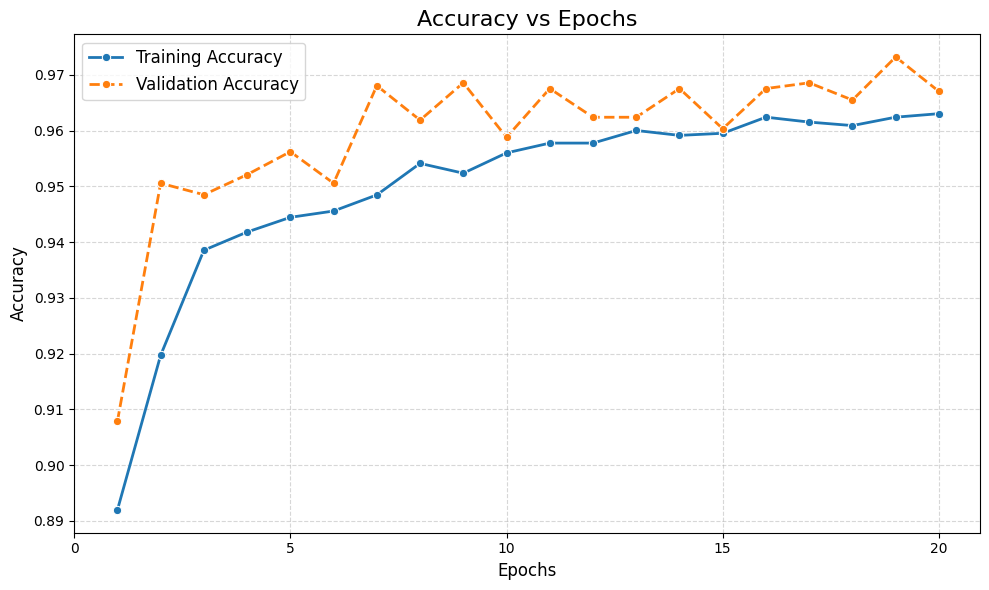

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'history' is the output from model.fit()
# Extract accuracy and epochs from history
epochs = range(1, len(history.history['accuracy']) + 1)
data = {
    'Epochs': list(epochs),
    'Training Accuracy': history.history['accuracy'],
    'Validation Accuracy': history.history['val_accuracy']
}

# Convert data to a Pandas DataFrame for easier plotting
df = pd.DataFrame(data)

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Epochs', y='Training Accuracy', marker='o', label='Training Accuracy', linewidth=2)
sns.lineplot(data=df, x='Epochs', y='Validation Accuracy', marker='o', label='Validation Accuracy', linewidth=2, linestyle='--')
plt.title('Accuracy vs Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.xticks(ticks=range(0, len(epochs) + 1, 5))
plt.ylabel('Accuracy', fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [61]:
model.save('pca.h5')

## testing goes here

In [10]:
model = tf.keras.models.load_model('pca.h5')

# Show the model architecture
model.summary()

Model: "CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)      │ (None, 16, 16, 1)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv2D_Kernel_2 (Conv2D)      │ (None, 16, 16, 64)        │             320 │ Input_Layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv2D_Kernel_3 (Conv2D)      │ (None, 16, 16, 64)        │             640 │ Input_Layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv2D_Kernel_4 (Conv2D)      │ (None, 16, 16, 64)        │           1,088 │ Input_Layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv2D_Kernel_5 (Conv2D)      │ (None, 16, 16, 64)        │           1,664 │ Input_Layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv2D_Kernel_6 (Conv2D)      │ (None, 16, 16, 64)        │           2,368 │ Input_Layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv2D_Kernel_7 (Conv2D)      │ (None, 16, 16, 64)        │           3,200 │ Input_Layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv2D_Kernel_8 (Conv2D)      │ (None, 16, 16, 64)        │           4,160 │ Input_Layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Dropout_Conv2D_2 (Dropout)    │ (None, 16, 16, 64)        │               0 │ Conv2D_Kernel_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Dropout_Conv2D_3 (Dropout)    │ (None, 16, 16, 64)        │               0 │ Conv2D_Kernel_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Dropout_Conv2D_4 (Dropout)    │ (None, 16, 16, 64)        │               0 │ Conv2D_Kernel_4[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Dropout_Conv2D_5 (Dropout)    │ (None, 16, 16, 64)        │               0 │ Conv2D_Kernel_5[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Dropout_Conv2D_6 (Dropout)    │ (None, 16, 16, 64)        │               0 │ Conv2D_Kernel_6[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Dropout_Conv2D_7 (Dropout)    │ (None, 16, 16, 64)        │               0 │ Conv2D_Kernel_7[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Dropout_Conv2D_8 (Dropout)    │ (None, 16, 16, 64)        │               0 │ Conv2D_Kernel_8[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ GlobalMaxPooling_Kernel_2     │ (None, 64)                │               0 │ Dropout_Conv2D_2[0][0]     │
│ (GlobalMaxPooling2D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ GlobalMaxPooling_Kernel_3     │ (None, 64)                │               

 Total params: 71,172 (278.02 KB)

 Trainable params: 71,170 (278.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [27]:
y_true = []
y_pred = []

for X_batch, Y_batch in val_dataset:
    predictions = model.predict(X_batch)  # Shape: (batch_size, 2)
    predicted_classes = np.argmax(predictions, axis=1)  # Get class indices (0 or 1)
    y_true.extend(Y_batch.numpy())  # Add true labels
    y_pred.extend(predicted_classes)  # Add predictions

y_true = np.array(y_true)
y_pred = np.array(y_pred)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━

In [28]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[  85  107]
 [ 195 1569]]


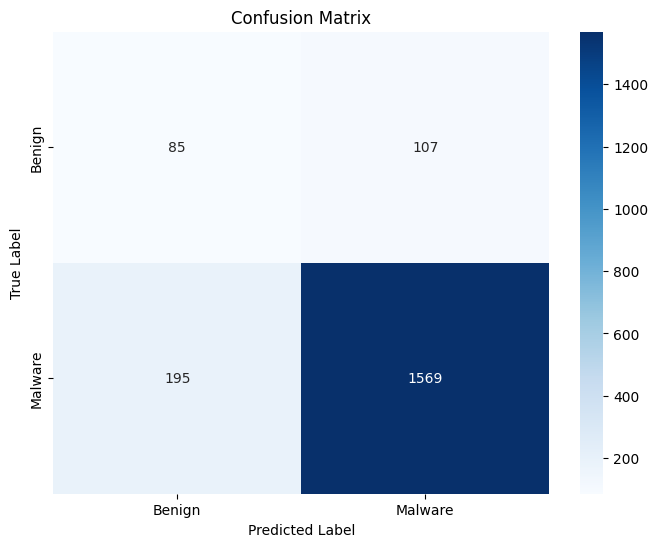

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(8, 6 ))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malware"], yticklabels=["Benign", "Malware"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()